# UCLA Results Validation

This notebook is aimed at attemping to validate the results achieved by UCLA in their paper

In [105]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
%reload_ext autoreload

In [104]:
from protestDB import cursor
from protestDB import models
from lib import analysis_utils as au
import pandas as pd
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot
from sklearn import preprocessing as skpreprocess
from sklearn import metrics
from keras.preprocessing.image import ImageDataGenerator
import scipy
from keras.models import Model
from keras import backend as K
from keras.applications import ResNet50
from keras.layers import Dense, Input, Flatten, Concatenate
from keras import losses
import h5py
import matplotlib.pyplot as plt
from keras import callbacks, optimizers

### Loading up the data

In [85]:
# Take a sample of 500 images and their respective labels
pc = cursor.ProtestCursor()
imgs = pc.query(models.Images).filter(models.Images.source == 'UCLA')


Get the labels

In [86]:

headers = ["name", "protest", "violence", "sign", "photo", "fire", "police", "children", "group_20", "group_100", "flag", "night", "shouting"]
df = pd.DataFrame(columns=headers)
indx_non_violence = []

for indx, im in enumerate(imgs[:300]):
    tags = im.tags
    values = {}
    values['name'] = im.name
    
    label = im.labels
    if len(label) == 1:
        values['violence'] = label[0].label
    elif len(label) == 0:
        values['violence'] = 0
        indx_non_violence.append(indx) # save the index of a image without label for later removing value
    else:
        raise ValueError("there should not be more than one label")
    
    for tag in tags:
        if tag.tagName == 'ucla-test': continue # ignore this
        values[tag.tagName] = 1
    df = df.append(values, ignore_index=True)




### Pre-processing

In [36]:
# Apply a cut point and normalize violence scores
cutpoint = 0.6

#clips
df = au.ClipDFColumn(df, 'violence', cutpoint)

# normalize
df = au.MinMax(df, 'violence')

# mask values that did not had violence labels
df.loc[indx_non_violence, 'violence'] = -1

# masks the visual attributes that where image is not a protest
for column, value in df.iloc[:,3:].iteritems(): # fill visual attributes with masking
    df.loc[pd.isnull(df['protest']), column] = -1
    
# fill nas
df = df.fillna(0)
df

,name,protest,violence,sign,photo,fire,police,children,group_20,group_100,flag,night,shouting
0,test-00000.jpg,1,0.632513,1,0.0,0.0,0.0,0.0,1,1,0.0,1,0.0
1,test-00001.jpg,0,-1.000000,-1,-1.0,-1.0,-1.0,-1.0,-1,-1,-1.0,-1,-1.0
2,test-00002.jpg,1,0.370518,1,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0
3,test-00003.jpg,0,-1.000000,-1,-1.0,-1.0,-1.0,-1.0,-1,-1,-1.0,-1,-1.0
4,test-00004.jpg,0,-1.000000,-1,-1.0,-1.0,-1.0,-1.0,-1,-1,-1.0,-1,-1.0
5,test-00005.jpg,0,-1.000000,-1,-1.0,-1.0,-1.0,-1.0,-1,-1,-1.0,-1,-1.0
6,test-00006.jpg,0,-1.000000,-1,-1.0,-1.0,-1.0,-1.0,-1,-1,-1.0,-1,-1.0
7,test-00007.jpg,0,-1.000000,-1,-1.0,-1.0,-1.0,-1.0,-1,-1,-1.0,-1,-1.0
8,test-00008.jpg,0,-1.000000,-1,-1.0,-1.0,-1.0,-1.0,-1,-1,-1.0,-1,-1.0
9,test-00009.jpg,0,-1.000000,-1,-1.0,-1.0,-1.0,-1.0,-1,-1,-1.0,-1,-1.0


Get the images

In [37]:
batch_size = 8

In [107]:
dummy_test_generator = au.ResizeSequence(df[:5], batch_size, 
                                         targets = ['protest', 'violence', df.columns[3:].tolist()])
train_generator = au.ResizeSequence(df[:100], batch_size, 
                                    targets = ['protest', 'violence', df.columns[3:].tolist()])
validation_generator = au.ResizeSequence(df[100:200], batch_size, 
                                         targets = ['protest', 'violence', df.columns[3:].tolist()])
test_generator = au.ResizeSequence(df[200:300], batch_size, 
                                   targets = ['protest', 'violence', df.columns[3:].tolist()])

/home/lucas/Documents/ITU/Thesis_2018/venv/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  import sys


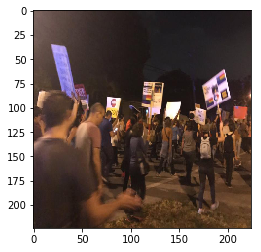

In [109]:
# test generator
first = dummy_test_generator.__getitem__(0)
image = first[0][0]
#protest = first[1][:,0]
#violence = first[1][:,1]
#visual = first[1][:,2:]
img = scipy.misc.toimage(image)
pyplot.imshow(img)
#print("protest has shape", protest.shape, " violence has shape", violence.shape, " visual has shape", visual.shape)

Select training and validation sets

### Modeling

In [110]:
mask_value = -1
K.clear_session()

In [112]:
img_input = Input(shape=(224,224,3), name='img_input')
resnet_model = ResNet50(include_top=False, weights = 'imagenet') (img_input)
flatten = Flatten()(resnet_model)
protest_out = Dense(1, activation='sigmoid', name='protest_out')(flatten)
violence_out = Dense(1, activation='sigmoid', name='violence_out')(flatten)
visual_out = Dense(10, activation='sigmoid', name='visual_out')(flatten)
#concact = Concatenate(protest_out, violence_out, visual_out )

#model = Model(inputs= img_input, outputs=concat)
model = Model(inputs= img_input, outputs=[protest_out, violence_out, visual_out])
model.compile(optimizer='rmsprop',
              loss={'protest_out': losses.binary_crossentropy,
                    'visual_out': au.BuildMaskedLoss(losses.binary_crossentropy, mask_value), 
                    'violence_out': au.BuildMaskedLoss(losses.mean_squared_error, mask_value)},
              loss_weights={'protest_out': 1., 
                            'visual_out': 5, 
                            'violence_out': 10 })
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
resnet50 (Model)                multiple             23587712    img_input[0][0]                  
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 2048)         0           resnet50[1][0]                   
__________________________________________________________________________________________________
protest_out (Dense)             (None, 1)            2049        flatten_2[0][0]                  
__________________________________________________________________________________________________
violence_o

In [113]:
lr = 0.01; momentum = 0.9; epochs = 5

In [117]:
change_lr = callbacks.LearningRateScheduler(au.LrUpdateUCLA, verbose = True)
optimizers.sgd = optimizers.SGD(lr=lr, momentum=momentum, nesterov=False)

history = model.fit_generator(
    train_generator,
    validation_data= validation_generator,
    epochs=epochs,
    callbacks = [change_lr])

Epoch 1/5

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.


StopIteration: 'the label [protest] is not in the [index]'

### Test set evaluation

In [58]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
def plot_roc(attr, target, pred):
    """Plot a ROC curve and show the accuracy score and the AUC"""
    fig, ax = plt.subplots()
    auc = roc_auc_score(target, pred)
    acc = accuracy_score(target, (pred >= 0.5).astype(int))
    fpr, tpr, _ = roc_curve(target, pred)
    plt.plot(fpr, tpr, lw = 2, label = attr.title())
    plt.legend(loc = 4, fontsize = 15)
    plt.title(('ROC Curve for {attr} (Accuracy = {acc:.3f}, AUC = {auc:.3f})'
               .format(attr = attr.title(), acc= acc, auc = auc)),
              fontsize = 15)
    plt.xlabel('False Positive Rate', fontsize = 15)
    plt.ylabel('True Positive Rate', fontsize = 15)
    plt.show()
    #return fig

In [31]:
preds = model.predict(test_X); preds_protest = preds[0]; preds_visual = preds[1]; preds_violence = preds[2]

### Protest

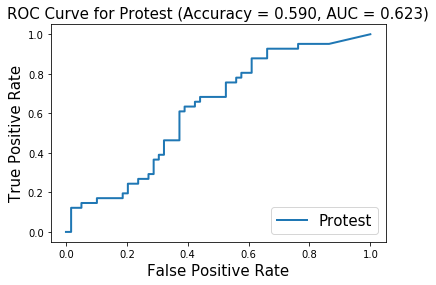

In [60]:
attr = "protest"
plot_roc(attr, test_protest, preds_protest)

### Visual

sign


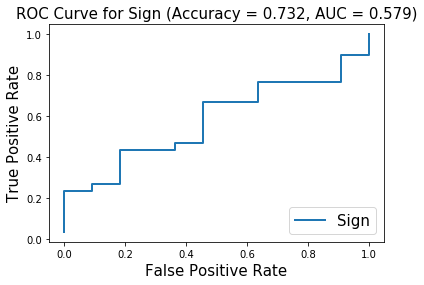

photo


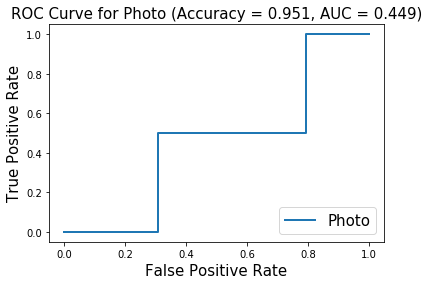

fire


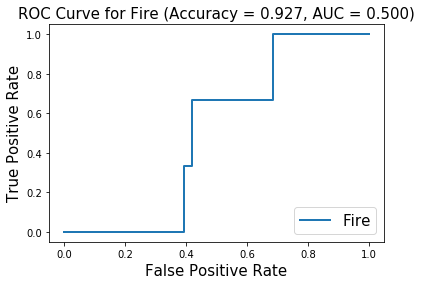

police


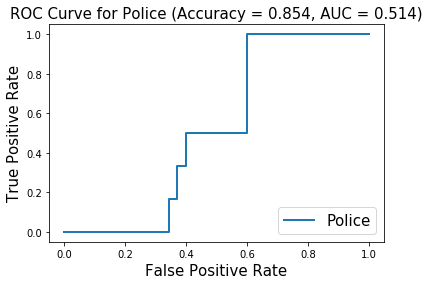

children
Only one class present in y_true. ROC AUC score is not defined in that case.
group_20


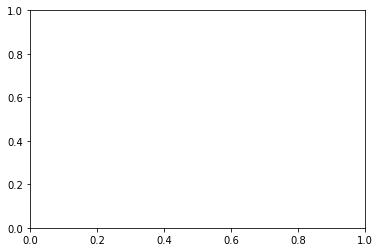

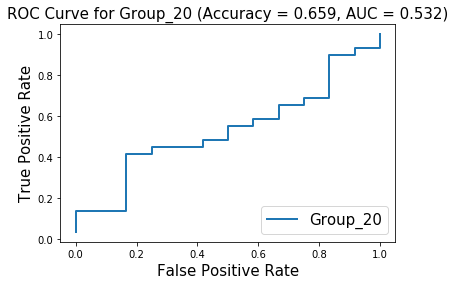

group_100


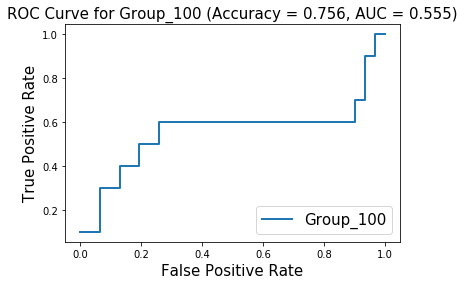

flag


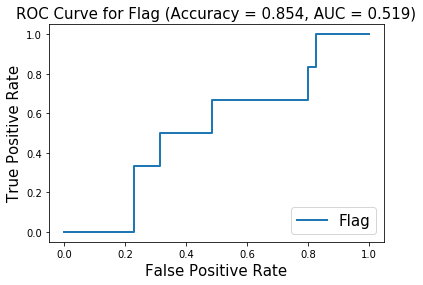

night


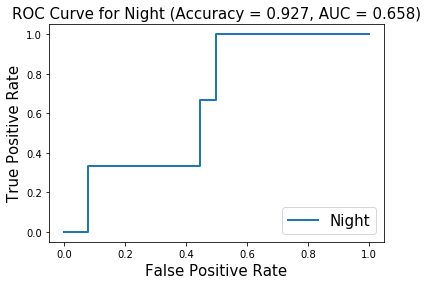

shouting


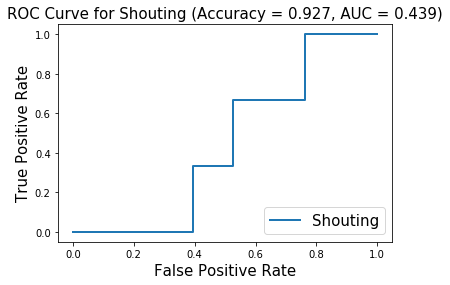

In [59]:
for i in range(preds_visual.shape[1]):
    pred = preds_visual[:,i]
    target = test_visual[:,i]
    
    # remove masked values from test set
    target_non_masked = target[target!= -1]
    pred_non_masked = pred[target!= -1]
    
    attr_indx = 3 + i # the visual attributes start from the 4th pos
    attr = df.columns[attr_indx]
    print(attr)
    try:
        plot_roc(attr, target_non_masked, pred_non_masked)
    except Exception as e:
        print(e)

### Violence

In [61]:
# remove masked values from test set
non_masked_violence_true = test_violence[test_violence!= -1].tolist()
non_masked_violence_preds = preds_violence[test_violence!= -1].flatten().tolist()

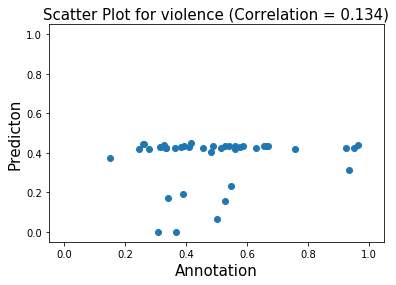

In [62]:
import scipy.stats as stats
fig, ax = plt.subplots()
plt.scatter(non_masked_violence_true, non_masked_violence_preds, label = "violence")
plt.xlim([-.05,1.05])
plt.ylim([-.05,1.05])
plt.xlabel('Annotation', fontsize = 15)
plt.ylabel('Predicton', fontsize = 15)
corr, pval = stats.pearsonr(non_masked_violence_true, non_masked_violence_preds)
plt.title(('Scatter Plot for {attr} (Correlation = {corr:.3f})'
            .format(attr = "violence", corr= corr)), fontsize = 15)
plt.show()